In [2]:
%pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [72]:
import os

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

MODEL_ID = "models/gemini-2.5-pro-exp-03-25" # "gemini-2.5-flash-preview-04-17" # "gemini-2.0-flash" 

## Part 1: Build a Basic Chatbot¶

In [2]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key "messages". This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages ar already in the state.

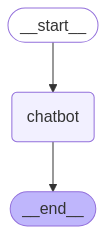

In [4]:
from IPython.display import Image

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

Image(graph.get_graph().draw_mermaid_png())

In [5]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [6]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about LangGraph?"
        print("User :" + user_input) 
        stream_graph_updates(user_input)
        break

Assistant: Hi there! How can I help you today?
Assistant: I am a large language model, trained by Google. I am designed to provide information and complete tasks as instructed. My primary function is to generate human-quality text. This means I can:

*   **Answer your questions:** I can provide information on a wide range of topics, drawing from the vast amount of text data I have been trained on.
*   **Write different kinds of creative content:** I can write stories, poems, articles, scripts, musical pieces, email, letters, etc.
*   **Translate languages:** I can translate text from one language to another.
*   **Summarize text:** I can provide concise summaries of long articles or documents.
*   **Generate different creative text formats,** of text, like poems, code, scripts, musical pieces, email, letters, etc. I will try my best to fulfill all your requirements.

Essentially, I am a tool that can help you with a variety of text-based tasks.
Goodbye!


## Part 2: 🛠️ Enhancing the Chatbot with Tools¶

In [8]:
%pip install -qU tavily-python langchain_community


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).\n\nSimilar to NetworkX, you add these nodes to a graph using the add_node method:\n\nAPI Reference: RunnableConfig | StateGraph [...] LangGraph Glossary¶\n\nGraphs¶\n\nAt its core, LangGraph models agent workflows as graphs. You define the behavior of your agents using three key components:\n\nState: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.\n\nNodes: Python functions that encode the logic of your agents. They receive the current State as input, perform some computation or side-effect, and ret

In [11]:
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

In [12]:
import json

from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

In [13]:
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

In [14]:
from typing import Literal
def route_tools(state: State) -> Literal["tools", "__end__"]:
    """Use in the conditional_edge to route to the ToolNode if the last message has tool calls. 
    Otherwise, route to the end"""
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [15]:
graph_builder.add_conditional_edges("chatbot", route_tools)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

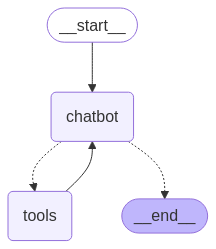

In [16]:
Image(graph.get_graph().draw_mermaid_png())

In [17]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hi, how can I help you today?
Assistant: 
Assistant: [{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for developing more complex, [...] [](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-21-6)   LangGraph is a library designed for building stateful, multi-actor applications with Large Language Models (LLMs). It's particularly useful for creating agent and multi-agent workflows.\n[](https://langchain-

## Part 3: Adding Memory to the Chatbot¶

In [18]:
# Create a MemorySaver chekpointer
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()  # SqliteSaver, PostgresSaver

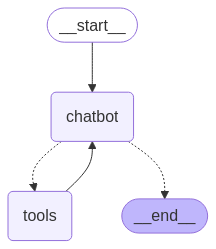

In [21]:
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)


graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile(checkpointer=memory)

Image(graph.get_graph().draw_mermaid_png())

In [22]:
config = {"configurable": {"thread_id": "1"}}

In [23]:
user_input = "Hi there! My name is Kim."

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Kim.
================================== Ai Message ==================================

Hi Kim, nice to meet you! How can I help you today?


In [24]:
user_input = "Remember my name?"

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Kim.


In [25]:
# The only difference is we change the 'thread_id' here to "2" instead of "1"
config = {"configurable": {"thread_id": "2"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I do not store any personal information, so I don't remember your name.


In [26]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='2d430d12-acce-40a6-ab37-ed23f5cccf6c'), AIMessage(content="I do not store any personal information, so I don't remember your name.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-8ccf2faa-febc-4df9-9a5b-26c8a4d3dcf9-0', usage_metadata={'input_tokens': 51, 'output_tokens': 18, 'total_tokens': 69, 'input_token_details': {'cache_read': 0}})]}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f020254-b93a-6710-8001-a8095f0acde9'}}, metadata={'source': 'loop', 'writes': {'chatbot': {'messages': [AIMessage(content="I do not store any personal information, so I don't remember your name.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings'

In [27]:
snapshot.next

()

## Part 4: Human-in-the-loop

In [1]:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatGoogleGenerativeAI(model=MODEL_ID)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools))
graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


In [2]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

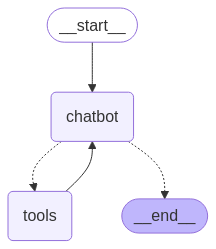

In [4]:
from IPython.display import Image, display

Image(graph.get_graph().draw_mermaid_png())

In [5]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

In [6]:
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (d2e23d0f-f01d-4a31-9bd0-c903ab03f11f)
 Call ID: d2e23d0f-f01d-4a31-9bd0-c903ab03f11f
  Args:
    query: expert guidance for building an AI agent


In [7]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [8]:
human_response = {
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
}

human_command = Command(resume={"data": human_response})

In [9]:
events = graph.stream(
    human_command,
    config,
    stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (d2e23d0f-f01d-4a31-9bd0-c903ab03f11f)
 Call ID: d2e23d0f-f01d-4a31-9bd0-c903ab03f11f
  Args:
    query: expert guidance for building an AI agent
================================= Tool Message =================================
Name: human_assistance

{"We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents."}
================================== Ai Message ==================================

I have requested assistance for you. The experts recommend checking out LangGraph for building your AI agent, as it is considered more reliable and extensible than simple autonomous agents.


## Part 5: Customizing State¶


In [30]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str



In [31]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt

@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolId to signal that this argment should not
# be revealed to the model in the tool's schema.
def human_assistance(name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]) -> str:
    """Request assistance from human"""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday
        }
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitily update the state with a ToolMessage inside the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)]
    }
    # We return a Command object in the tool to update our state
    return Command(update=state_update)



In [32]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = ChatGoogleGenerativeAI(model=MODEL_ID)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [33]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": { "thread_id": "1"}}

In [34]:
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (a00a79b8-6cb3-4284-9730-e8f77b619de4)
 Call ID: a00a79b8-6cb3-4284-9730-e8f77b619de4
  Args:
    query: when was LangGraph released?
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Discovering LangGraph: Paving the Path to Reliable AI Systems", "url": "https://juancalvoferrandiz.medium.com/discovering-langgraph-paving-the-path-to-reliable-ai-systems-a9cd348c9d57", "content": "While Langchain’s Expression Language provides a declarative way to create custom chains as DAGs, many real-world use cases, such as refining search results or iterating on complex calculations, demand the adaptability of cy

In [35]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024"
    }
)

In [36]:
events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

LangGraph was released in mid-January 2024. However, another source says January 2023, with a stable 0.1 release in June. I will use the human_assistance tool to confirm.
Tool Calls:
  human_assistance (7d40d2b7-0d94-4c5f-9901-24b405ce81dd)
 Call ID: 7d40d2b7-0d94-4c5f-9901-24b405ce81dd
  Args:
    birthday: January 2024
    name: LangGraph Release Date
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph was released around mid-January 2024, specifically January 17, 2024. I have requested human assistance to confirm this.


In [37]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

### Manually updating state

In [38]:
graph.update_state(config, {"name": "LangGraph (library)"})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f020d0c-528f-6264-8006-dc3ecb86851e'}}

In [39]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph (library)', 'birthday': 'Jan 17, 2024'}

## Part 6: Time Travel¶


In [87]:
# Let's use the simaple chatbot with tools from Part 3:
from typing import Annotated
from typing_extensions import TypedDict

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]




In [88]:
graph_builder = StateGraph(State)

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatGoogleGenerativeAI(model=MODEL_ID)
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)


In [89]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {"messages": [{"role": "user", "content": ("I'm learning LangGraph. "
                                               "Could you do some research on it for me?")}]},
    config,
    stream_mode="values"
)

In [90]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

Okay, I can help you with that. I'll use the search tool to gather information about LangGraph.
Tool Calls:
  tavily_search_results_json (6273fe37-9966-4d92-9921-276832416c53)
 Call ID: 6273fe37-9966-4d92-9921-276832416c53
  Args:
    query: What is LangGraph?
  tavily_search_results_json (152e0938-a9bd-4cda-8430-1e718e8cc8a6)
 Call ID: 152e0938-a9bd-4cda-8430-1e718e8cc8a6
  Args:
    query: LangGraph key concepts and use cases
  tavily_search_results_json (58ee4da4-72c1-4abb-b0ca-55c41a9c1363)
 Call ID: 58ee4da4-72c1-4abb-b0ca-55c41a9c1363
  Args:
    query: LangGraph relationship to LangChain
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "LangGraph - LangChain Blog", "url": "https

In [91]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That's a fantastic idea! LangGraph is particularly well-suited for building autonomous agents precisely because of its ability to handle complex, cyclical workflows.

Here's why it's a good fit and some things you might think about as you start:

1.  **Agentic Loops:** Autonomous agents often involve loops like:
    *   **Plan:** Decide on the next steps based on the objective and current state.
    *   **Act:** Execute a step (e.g., use a tool, call an LLM).
    *   **Observe:** See the result of the action.
    *   **Reflect/Update:** Update the plan or state based on the observation.
    LangGraph's support for cycles makes modeling these loops much more natural than purely linear chains.

2.  **State Management:** Agents need memory. LangGraph's state manag

In [98]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Massages: ", len(state.values["messages"]), "Next: ", state.next)
    if "messages" in state.values and len(state.values["messages"])>0:
        print("Message: ", state.values["messages"][-1].content[:100])
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Massages:  8 Next:  ()
Message:  That's a fantastic idea! LangGraph is particularly well-suited for building autonomous agents precis
--------------------------------------------------------------------------------
Num Massages:  7 Next:  ('chatbot',)
Message:  Ya that's helpful. Maybe I'll build an autonomous agent with it!
--------------------------------------------------------------------------------
Num Massages:  6 Next:  ('__start__',)
Message:  Okay, I've done some research on LangGraph. Here's a breakdown of what it is and its key aspects:

1
--------------------------------------------------------------------------------
Num Massages:  6 Next:  ()
Message:  Okay, I've done some research on LangGraph. Here's a breakdown of what it is and its key aspects:

1
--------------------------------------------------------------------------------
Num Massages:  5 Next:  ('chatbot',)
Message:  [{"title": "LangGraph - LangChain Blog", "url": "https://blog.langchain.dev/langgraph/", "c

In [100]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f020e4a-9abf-6752-8003-4a23942e7a64'}}


In [101]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Okay, I've done some research on LangGraph. Here's a breakdown of what it is and its key aspects:

1.  **What is LangGraph?**
    *   LangGraph is a library built as an extension *on top of* the popular LangChain framework.
    *   Its primary purpose is to enable the creation of complex, stateful applications, particularly AI agents, using graph-based structures.
    *   Instead of just linear sequences of operations (like many basic LangChain chains), LangGraph allows you to define workflows as *graphs* with nodes (representing functions or LLM calls) and edges (representing the flow of control and data).

2.  **Key Concepts & Features:**
    *   **Cyclical Graphs:** This is a major differentiator. LangGraph makes it easy to create graphs that have cycles or loops. This is crucial for building sophisticated agents that might need to retry steps, iterate on results, or make decisions based on intermediat

## Quickstart: Launch Local LangGraph Server<sup>[1](https://langchain-ai.github.io/langgraph/tutorials/langgraph-platform/local-server/)</sup>

In [ ]:
%pip install --upgrade "langgraph-cli[inmem]"

In [ ]:
%langgraph new app/react-agent --template react-agent-python

In [ ]:
%cd app/react-agent/
%pip install -e .

In [102]:
%pip install langgraph-sdk


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%langgraph dev

```
$ langgraph dev
INFO:langgraph_api.cli:

        Welcome to

╦  ┌─┐┌┐┌┌─┐╔═╗┬─┐┌─┐┌─┐┬ ┬
║  ├─┤││││ ┬║ ╦├┬┘├─┤├─┘├─┤
╩═╝┴ ┴┘└┘└─┘╚═╝┴└─┴ ┴┴  ┴ ┴

- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs

This in-memory server is designed for development and testing.
For production use, please use LangGraph Cloud.
```

In [1]:
from langgraph_sdk import get_client

client = get_client(url="http://localhost:2024")

async for chunk in client.runs.stream(
    None,  # Threadless run
    "agent", # Name of assistant. Defined in langgraph.json.
    input={
        "messages": [{
            "role": "human",
            "content": "What is LangGraph?",
        }],
    },
    stream_mode="updates",
):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1f02583a-65a2-6df0-b1fd-96b7649d7279', 'attempt': 1}



Receiving new event of type: updates...
{'call_model': {'messages': [{'content': 'LangGraph는 LLM(대규모 언어 모델)을 사용하여 상태 저장, 다중 행위자 애플리케이션을 구축하기 위한 라이브러리입니다. LangChain 생태계의 일부이며, 순환 그래프로 에이전트와 같은 애플리케이션을 만드는 방법을 제공합니다.\n\n이는 LangChain의 체인(종종 방향성 비순환 그래프로 제한됨)을 확장하여 보다 복잡한 상호 작용과 흐름 제어가 필요한 애플리케이션에 필수적인 순환을 도입합니다. LangGraph를 사용하면 여러 행위자 또는 구성 요소가 조정된 방식으로 함께 작동하고 공유 상태를 수정하는 애플리케이션을 만들 수 있습니다.\n\n주요 특징은 다음과 같습니다.\n\n1.  **그래프 기반 표현:** 흐름이 노드(단계 또는 행위자)와 에지(전환)로 표시됩니다.\n2.  **상태 저장:** 그래프 전체 실행에 걸쳐 상태가 명시적으로 전달되고 업데이트됩니다.\n3.  **순환 지원:** 표준 LangChain 체인과 달리 복잡한 대화, 반복 또는 수정이 필요한 에이전트 동작에 필수적인 순환 흐름을 허용합니다.\n4.  **유연성:** 복잡한 에이전트 팀 또는 다중 단계 추론 프로세스를 구축하는 데 적합합니다.', 'additional_kwargs': {}, 'response_metadata': {'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-pro-exp-03-25', 'safety_ratings': []}, 'type': 'ai', 'name': Non